## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease                
Hit:3 http://archive.ubuntu.com/ubuntu bionic-backports InRelease              
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease              
Reading package lists... Done                                   
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libatlas-base-dev is already the newest version (3.10.3-5).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.


## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(1, 2):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:58<00:00,  4.19it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_1"])
layer_hs_array.shape

(10000, 267264)

## Layer 1 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

dim_reduced_vecs = layer_hs_array

# random_projector = GaussianRandomProjection(random_state = 42)
# dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 267264)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 267264)
(8000,)
(2000, 267264)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 267264D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 3.87 s
Outer iteration 0 / 10
  Iteration 19 (11.02 s, search 7.36 s): objective=1757.38 imbalance=1.097 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (22.06 s, search 14.73 s): objective=1753.72 imbalance=1.085 nsplit=0       
Outer iteration 2 / 10
  Iteration 19 (33.08 s, search 22.09 s): objective=1749.07 imbalance=1.043 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (44.10 s, search 29.45 s): objective=1753.39 imbalance=1.077 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (55.11 s, search 36.79 s): objective=1756.19 imbalance=1.434 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (66.13 s, search 44.15 s): objective=1753.1 imbalance=1.076 nsplit=0        
Outer iteration 6 / 10
  Iteration 19 (77.16 s, search 51.50 s): objective=1749.23 imbalance=1.059 nsplit=0       
Outer it

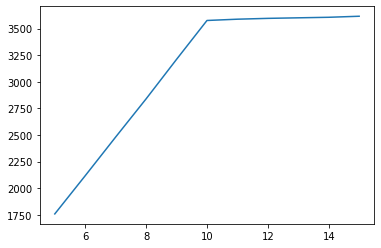

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [15]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 267264D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 1.15 s
Outer iteration 0 / 10
  Iteration 19 (21.87 s, search 14.72 s): objective=3563.92 imbalance=1.097 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (43.74 s, search 29.44 s): objective=3571.52 imbalance=1.167 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (65.59 s, search 44.15 s): objective=3574.14 imbalance=1.084 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 10
  Iteration 19 (87.42 s, search 58.85 s): objective=3571.88 imbalance=1.061 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (109.31 s, search 73.56 s): objective=3554.74 imbalance=1.323 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (131.19 s, search 88.28 s): objective=3572.25 imbalance=1.118 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (153.05 s, search 103.00 s): objective=3575.66 imb

3575.657958984375

In [16]:
kmeans.centroids #cluster centers

array([[ 1.0959357e-02,  4.7439276e-03,  1.5292769e-02, ...,
         1.8194955e-06,  6.7617378e-07,  5.4385346e-06],
       [ 1.1914627e-02,  5.1574293e-03,  1.6625762e-02, ...,
        -6.2291218e-07,  1.3301746e-05,  2.0536694e-05],
       [ 1.2715629e-02,  5.5041569e-03,  1.7743485e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 1.1211236e-02,  4.8529608e-03,  1.5644258e-02, ...,
        -1.8580162e-06,  9.8734944e-08, -1.9872675e-06],
       [ 1.2781084e-02,  5.5324896e-03,  1.7834829e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.2791999e-02,  5.5372100e-03,  1.7850062e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [17]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0000515
1.0000601
1.0000116
1.0000545
1.0000118
1.0000325
1.0000429
1.0000598
1.0000188
1.0000169


In [18]:
kmeans.obj #inertia at each iteration

array([2114.39575195, 3430.43945312, 3503.72241211, 3529.99707031,
       3539.47509766, 3545.89160156, 3551.23535156, 3554.97998047,
       3557.17675781, 3558.3918457 , 3559.11450195, 3559.6081543 ,
       3560.03564453, 3560.453125  , 3560.94140625, 3561.49511719,
       3562.10522461, 3562.69726562, 3563.375     , 3563.91577148,
       2215.04980469, 3423.35839844, 3475.1472168 , 3499.17504883,
       3516.47070312, 3537.77636719, 3550.25219727, 3556.08691406,
       3560.19726562, 3563.36987305, 3565.82836914, 3567.77001953,
       3568.8815918 , 3569.60058594, 3570.13769531, 3570.5390625 ,
       3570.85595703, 3571.14233398, 3571.33959961, 3571.51806641,
       2118.41577148, 3426.65307617, 3491.98608398, 3516.66381836,
       3532.25048828, 3543.74829102, 3554.07666016, 3561.35522461,
       3566.74609375, 3569.15722656, 3570.49829102, 3571.39477539,
       3571.9465332 , 3572.43066406, 3572.79394531, 3573.10522461,
       3573.38037109, 3573.64550781, 3573.89086914, 3574.13916

In [19]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [20]:
pd.Series(classifications_train).value_counts()

5    1234
2    1087
3     959
7     950
4     769
0     711
1     698
9     623
8     490
6     479
dtype: int64

In [21]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[5, 10, 5, 1, 9, 4, 4, 2, 6, 3]

In [22]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [23]:
centroid_to_label

{0: 5, 1: 10, 2: 5, 3: 1, 4: 9, 5: 4, 6: 4, 7: 2, 8: 6, 9: 3}

In [24]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 2,  4,  1, ..., 10, 10, 10])

In [25]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.26375
Prompt 2 Accuracy:  0.275
Prompt 3 Accuracy:  0.2725
Prompt 4 Accuracy:  0.42875
Prompt 5 Accuracy:  0.72
Prompt 6 Accuracy:  0.17
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.20375
Prompt 10 Accuracy:  0.855


In [26]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.318875


## Perform Inference on Test Set & Collect Test Accuracy

In [27]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [28]:
pd.Series(classifications_test).value_counts()

5    292
2    265
3    255
7    236
4    197
0    176
1    170
9    168
6    121
8    120
dtype: int64

In [29]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 9,  1,  5, ..., 10, 10, 10])

In [30]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.28
Prompt 2 Accuracy:  0.225
Prompt 3 Accuracy:  0.295
Prompt 4 Accuracy:  0.375
Prompt 5 Accuracy:  0.755
Prompt 6 Accuracy:  0.13
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.215
Prompt 10 Accuracy:  0.825


In [31]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.31


## Confusion Matrix of Results

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

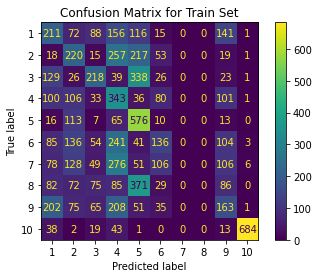

In [33]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

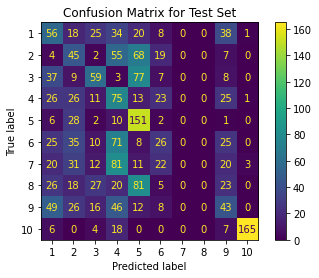

In [34]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()